<p><b>Intro:</b> I performed the following analysis for my intermediate data programming with Python class at the University of Washington. The assignment called for us to to select a data set, identify research questions and then perform an analysis to answer said questions. This project attempted to assess the value of the NBA combine in terms of evaluating prospects by attempting to determine if any of the combine measurements was a strong predictor of in game performance. In order to compensate for differences in playing styles I primarily used a metric called composite metric called win shares, which attempts to assign “credit” for winning a certain number of games to a particular athlete. I also used PPG and noted other relationships between in game statistics and combine measurements that seemed significant. 

<P>For ease of use I've put most of my write-up and my python code into a Jupyter notebook for easier review and recreation of my results. I've also made a few tweaks or revisions to improve the project beyond what I originally turned in. However, the notebook is quite extensive so there is a PDF that provides a high-level summary of the results and methodology, along with a list of assumptions and caveats.  Finally, I've added a section at the end where I discuss future related analyses I'd like to perform. 

<b>The research questions were as follows:</b>

1. How good are the NBA’s methods for evaluating talent overall? Meaning: is there a strong relationship between draft position and in game performance? Are “draft busts” where players significantly underperform relative to their draft position rare or common? 
2. Is there a significant relationship between draft position and combine performance? Going to Kevin Durant’s statements, does the combine hold any value for the athletes?
3. Are there any relationships, patterns or strong correlations between NBA combine performance and in game statistics like PPG and WS? E.g. do faster and more agile players score more points? 


In [3]:
# first we import all the packages we're going to use for this project 
# it's worth noting that there are packages here that this version of the project didn't use. 

import pandas as pd
import math
import os 
import glob2 as glob
import numpy as np
from sklearn import linear_model, metrics
import matplotlib.pyplot as plt 
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as seabornInstance 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import seaborn as sns
%matplotlib inline

In [5]:
# I used the glob package to open up a directory containing all of the csv files with the NBA season by season 
# player statistics and then merge them all into one data frame, where each subsequent csv is appended to the 
# end of the data frame. 


nba_df = pd.concat([pd.read_csv(f, header=1) for f in glob.glob(os.path.join('nba_stats', "*.csv"))], sort=False)
nba_df.shape

(4847, 33)

In [6]:
# according to the NBA you have to play 58 games in a season for 
# that season to be statistically significant as far as qualifying to be in the statistical rankings. 
# So we'll sort out only the seasons where an individual athlete played in at least 58 games. 


nba_min = nba_df[(nba_df['G'] >= 58)]
nba_min.shape



(2529, 33)

For this round of the analysis I just focused on whether or not an individual athlete had managed to complete a single 58 game season rather than having a minimum number of seasons. I.e. evaluating the ability of a given player to produce at least one statistically significant (and hopefully above average) NBA season, rather than evaluating longevity.

In [7]:
# sort out just the statistics we want to use in our analysis, dropping statistics due to being
# functions of other stats (E.g. FG%) or just to simplify our analysis. 


nba_subset = nba_min[['Player', 'Season', 'WS', 'G', 'MP', 'ORB', 'DRB',
                                'TRB','AST', 'STL', 'BLK', 'PTS', 'TOV']]


In [9]:
# calculate points per game, since it's not in the original data set 

nba_subset.loc[:,'PPG'] = nba_subset['PTS'] / nba_subset['G']

Now that we have the data for all of the NBA players, let's sort it by win shares and see who the leaders were over this seven year time period. 

In [10]:
nba_subset = nba_subset.sort_values('WS', ascending=False)
nba_subset.head(30)

,Player,Season,WS,G,MP,ORB,DRB,TRB,AST,STL,BLK,PTS,TOV,PPG
0,LeBron James,2012-13,19.3,76,2877,97,513,610,551,129,67,2036,226,26.789474
1,Kevin Durant,2013-14,19.2,81,3122,58,540,598,445,103,59,2593,285,32.012346
2,Kevin Durant,2012-13,18.9,81,3119,46,594,640,374,116,105,2280,280,28.148148
3,LeBron James,2009-10,18.5,76,2966,71,483,554,651,125,77,2258,261,29.710526
4,Stephen Curry,2015-16,17.9,79,2700,68,362,430,527,169,15,2375,262,30.063291
5,James Harden,2014-15,16.4,81,2981,75,384,459,565,154,60,2217,321,27.370370
7,Chris Paul,2014-15,16.1,82,2857,52,324,376,838,156,15,1564,190,19.073171
6,Kevin Durant,2009-10,16.1,82,3239,105,518,623,231,112,84,2472,271,30.146341
8,LeBron James,2013-14,15.9,77,2902,81,452,533,488,121,26,2089,270,27.129870
9,Stephen Curry,2014-15,15.7,80,2613,56,285,341,619,163,16,1900,249,23.750000


In [11]:
# count uniques in the player column just to see 
# the number of athletes represented in the dataset 

nba_subset['Player'].nunique()

692

The NBA player data set contains data on 546 total players across 1,784 "seasons" from the perspective of seasons represented for the players as whole, this also means that on average there are a little over three seasons per player. Looking at the data on the top 30 players, we can also see that only 12 players are represented in the top 30 seasons by win share. This suggests that in a typical draft very few if not none of the players will join the league's top echelons. Given this, we will evaluate drafting based on the probability that a player selected in the top 15 of draft is at minimum above average and ideally in the top 25% of NBA players statistically. 

<P>Now that we have the NBA dataset we'll use for our analysis, let's walk through some high-level stats for the dataset as a whole 


In [12]:
nba_subset.describe()

,WS,G,MP,ORB,DRB,TRB,AST,STL,BLK,PTS,TOV,PPG
count,2529.000000,2529.000000,2529.000000,2529.000000,2529.000000,2529.000000,2529.000000,2529.000000,2529.00000,2529.000000,2529.000000,2529.000000
mean,4.193199,72.222222,1850.041914,81.546066,248.976671,330.522341,172.988533,58.776592,37.51720,802.836299,104.901542,11.007937
std,2.938548,7.396039,586.837982,65.618253,135.497959,189.924047,142.893163,31.092214,35.49262,423.972868,58.351803,5.529088
min,-2.100000,58.000000,267.000000,5.000000,17.000000,22.000000,8.000000,6.000000,0.00000,62.000000,11.000000,0.968750
25%,2.100000,66.000000,1402.000000,33.000000,153.000000,192.000000,74.000000,36.000000,14.00000,484.000000,62.000000,6.870968
50%,3.600000,73.000000,1859.000000,59.000000,214.000000,284.000000,128.000000,53.000000,26.00000,724.000000,93.000000,9.920635
75%,5.700000,79.000000,2293.000000,113.000000,316.000000,419.000000,226.000000,76.000000,49.00000,1039.000000,134.000000,14.082192
max,19.300000,83.000000,3239.000000,440.000000,848.000000,1247.000000,907.000000,191.000000,269.00000,2818.000000,464.000000,36.128205


Some key pieces of information about our dataset includes:

* Average Win Share is 4.19 games with a standard deviation of 2.93 games 
* Average PPG is 11.008 with a standard deviation of 5.53
* The 75% percentile is interesting as well, 5.7  for Win Share and 14.082 for PPG

We'll use the average win share and PPG metrics  to see how the players in our combine data sets compare to the broader NBA dataset as a group, since there will be players in the NBA player data set that are not in the combine data set. We'll also use the data to evaluate things ranging from draft effectiveness to what % of NBA first round picks have produced elite seasons in terms of seasons in the top 25% of the league statistically. 

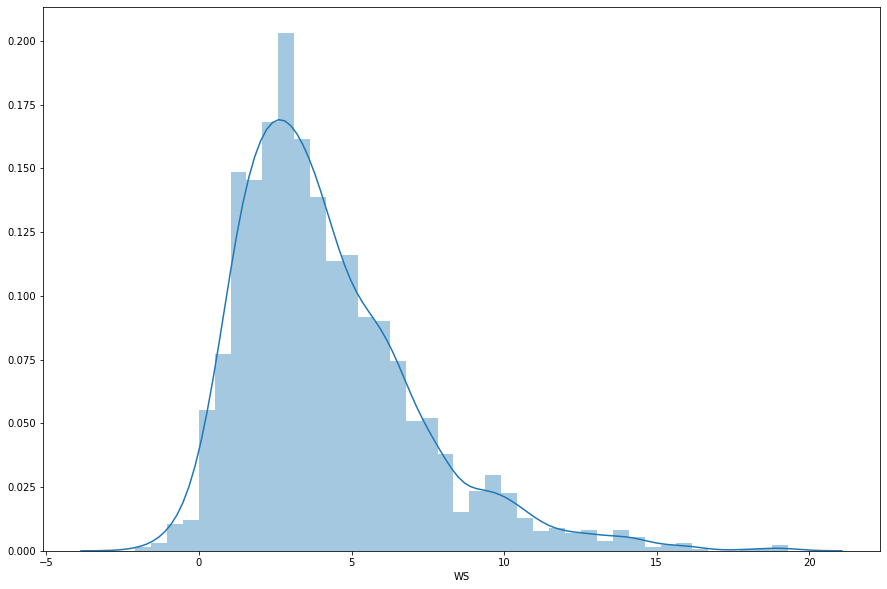

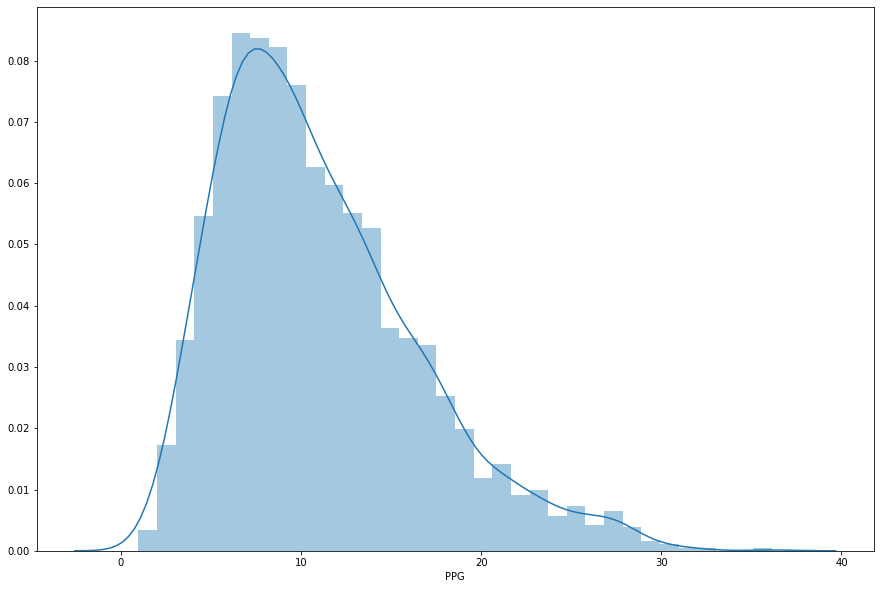

In [13]:
# let's look at the distribution of PPG and win share

plt.figure(figsize=(15,10))
plt.tight_layout()
seabornInstance.distplot(nba_subset['WS'])


plt.figure(figsize=(15,10))
plt.tight_layout()
seabornInstance.distplot(nba_subset['PPG'])




PPG is closer to being a normal distribution, but overall both distributions are skewed to the right. This more or less means that most players are grouped near the average, and the exceptional ones are rare/outliers, which suggests that our analysis is probably going to be better at predicting "good" rather than great players, as the great ones are so rare. 

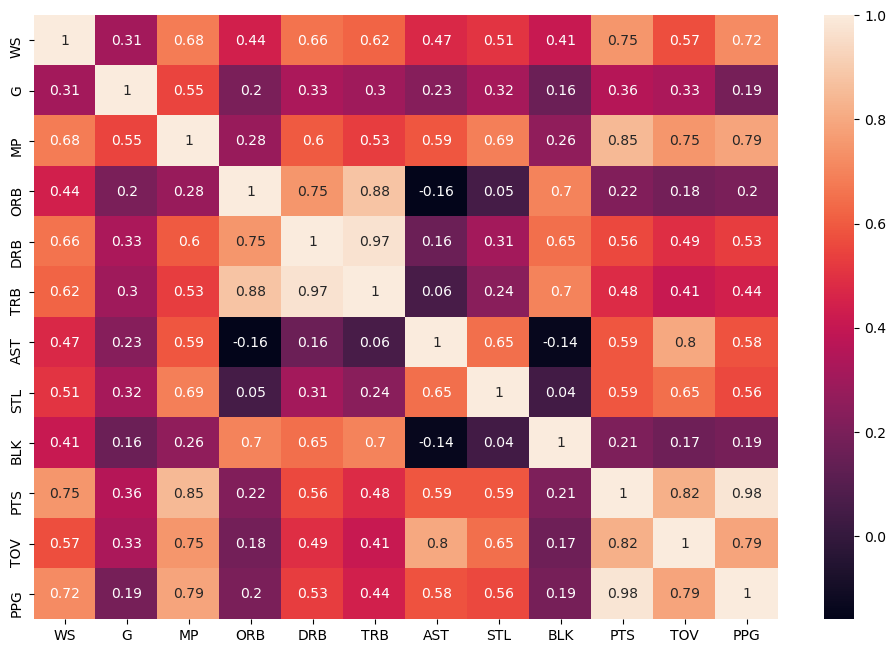

In [14]:
# Let's quickly evaluate our primary metric, how does WS correlate to other statistics in our data set?

# this code sets the size of our plots so they're easier to read 
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 

#calculates correlations and then uses the heatmap function of seaborn to plot it 
corr_ws = nba_subset.corr().round(2)
sns.heatmap(data=corr_ws, annot=True)


<P>Looking through the data we see a variety of patterns, and they all fairly logical and not particularly unexpected:

* Turnover has a high correlation with PPG, Points, Assists and Minutes Played, which suggests that the players who touch the ball the most due to their scoring, assists and the like are just more often in a position to make a mistake. It's also worth noting that the turnover number is the total number of turnovers, it's not expressed in terms of turnovers per touches. 
* Steals has a good correlation with assists and turnovers, which is interesting as it suggests that the players who turn over the ball the most are often the ones causing their opponents to do the same. It's also possible that in the process of stealing the ball they sometimes lose control and get both stats at the same time 
* TRB and BLKs have a strong correlation, which is a case of mathematics proving what makes intuitive sense, namely: players that are good at getting rebounds also tend to be good shot blockers. Again, this makes sense: if you have the height, leaping ability and good awareness of where the ball is to get a rebound, you can probably also apply those skills to blocking shots. 
* Win shares has its highest correlations with PPG (0.72), Defensive Rebounds (0.66) and Minutes Played (0.68), none of this is surprising, as it means that players who score a lot, take scoring opportunities away from opponents and are durable enough to play a lot of minutes are going to help their teams more. What's interesting are the items that weren't in the strong correlation or at least close category, namely: offensive rebounds (0.41) and assists (0.48), which probably means that the giving your team extra scoring chances or passing the ball to others that score isn't as valuable to your team as just scoring yourself. 

<P>For purposes of a visual let's make a linear regression plot of PPG vs. Win Share, just so we have a reference image of what a strong correlation looks like.


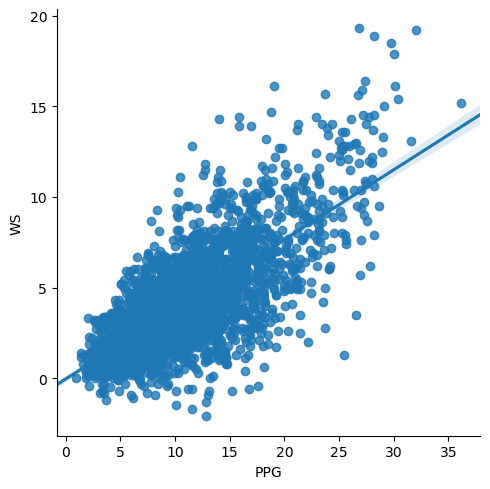

In [15]:


sns.lmplot(x="PPG", y="WS", data=nba_subset)


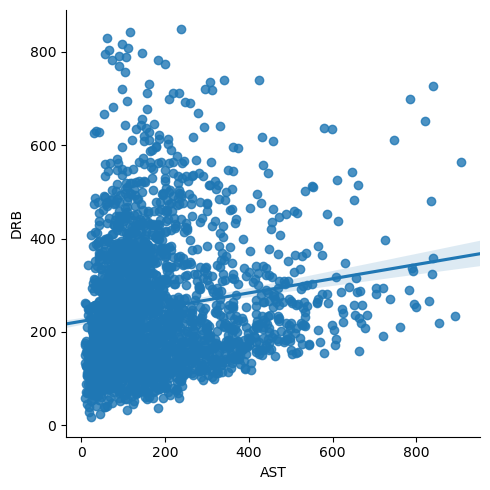

In [16]:
# Also for reference let's plot one of the weak correlations, assists vs. defensive rebounds

sns.lmplot(x="AST", y="DRB", data=nba_subset)

As we can see from the above, we have a very general trend line with a fairly weak slope and the individual data points scattered all over the graph. If the NBA Combine does in fact relate to in game performance, our linear model plots will look more like the first graph than they will the second. Before we merge the player stats data with the combine data, let's aggregate the data by player and then sort in descending order by Win Share.

In [17]:
nba_players = nba_subset.groupby('Player').mean()
nba_players = nba_players.sort_values('WS', ascending=False)

nba_players.head(30)

,WS,G,MP,ORB,DRB,TRB,AST,STL,BLK,PTS,TOV,PPG
Player,,,,,,,,,,,,
LeBron James,14.966667,74.555556,2795.111111,86.555556,481.000000,567.555556,561.000000,115.000000,53.666667,2005.000000,269.444444,26.875245
Kevin Durant,14.088889,74.222222,2748.777778,50.444444,503.333333,553.777778,331.000000,83.333333,87.555556,2084.333333,235.777778,27.960399
James Harden,12.180000,76.500000,2610.600000,58.200000,341.800000,400.000000,474.300000,118.900000,38.300000,1862.700000,277.000000,24.220056
Chris Paul,12.100000,67.222222,2274.333333,41.666667,251.444444,293.111111,637.222222,144.444444,10.111111,1214.333333,157.333333,18.077013
Stephen Curry,11.475000,77.125000,2687.000000,54.375000,293.500000,347.875000,517.500000,135.125000,17.250000,1823.250000,243.125000,23.666221
Karl-Anthony Towns,11.350000,80.750000,2780.000000,256.500000,701.250000,957.750000,209.750000,61.250000,120.250000,1796.750000,198.500000,22.283774
Rudy Gobert,11.100000,76.250000,2352.750000,274.000000,605.750000,879.750000,114.500000,56.000000,181.250000,916.000000,125.500000,11.846473
Anthony Davis,10.400000,68.333333,2376.333333,172.333333,533.333333,705.666667,127.333333,91.833333,164.333333,1601.166667,126.166667,23.184079
Damian Lillard,10.042857,78.428571,2843.857143,49.571429,277.428571,327.000000,497.000000,76.142857,24.428571,1844.142857,216.428571,23.635619


Looking at the data we see that LeBron James and Kevin Durant are the top two in terms of WS, while Kevin scores more points it appears that LeBron has a higher WS due to contributing more in other ways in terms of assists, rebounds and steals. 

In [18]:
# validate how many athletes are included 

total_athletes = len(nba_players)
total_athletes 

692

In [19]:
# Use pandas import combine data


all_combine_data = pd.read_csv('new_data/nba_draft_combine_all_years.csv')
all_combine_data

,Unnamed: 0,Player,Year,Draft pick,Height (No Shoes),Height (With Shoes),Wingspan,Standing reach,Vertical (Max),Vertical (Max Reach),Vertical (No Step),Vertical (No Step Reach),Weight,Body Fat,Hand (Length),Hand (Width),Bench,Agility,Sprint
0,0,Blake Griffin,2009,1.0,80.50,82.00,83.25,105.0,35.5,140.5,32.0,137.0,248.0,8.2,NaN,NaN,22.0,10.95,3.28
1,1,Terrence Williams,2009,11.0,77.00,78.25,81.00,103.5,37.0,140.5,30.5,134.0,213.0,5.1,NaN,NaN,9.0,11.15,3.18
2,2,Gerald Henderson,2009,12.0,76.00,77.00,82.25,102.5,35.0,137.5,31.5,134.0,215.0,4.4,NaN,NaN,8.0,11.17,3.14
3,3,Tyler Hansbrough,2009,13.0,80.25,81.50,83.50,106.0,34.0,140.0,27.5,133.5,234.0,8.5,NaN,NaN,18.0,11.12,3.27
4,4,Earl Clark,2009,14.0,80.50,82.25,86.50,109.5,33.0,142.5,28.5,138.0,228.0,5.2,NaN,NaN,5.0,11.17,3.35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,512,Peter Jok,2017,NaN,76.25,77.75,80.00,102.0,31.0,133.0,26.5,128.5,202.0,11.0,8.25,9.50,NaN,11.34,3.41
513,513,Rawle Alkins,2017,NaN,74.50,75.75,80.75,99.0,40.5,139.5,31.5,130.5,223.0,11.0,8.75,10.00,NaN,11.99,3.30
514,514,Sviatoslav Mykhailiuk,2017,NaN,78.50,79.50,77.00,100.0,33.0,133.0,27.0,127.0,220.0,11.4,8.00,9.25,NaN,12.40,3.53
515,515,Thomas Welsh,2017,NaN,83.50,84.50,84.00,109.5,NaN,NaN,NaN,NaN,254.0,10.9,9.00,10.50,NaN,NaN,NaN


Merge combine data with the NBA player statistics even though we don't have a full set of combine data for all the athletes, because since we do have draft position for all the players we can at least evaluate WS and PPG vs. draft position. 

In [20]:
combine_nba_merge = pd.merge(nba_players, all_combine_data, on='Player')
combine_nba_merge


,Player,WS,G,MP,ORB,DRB,TRB,AST,STL,BLK,...,Vertical (Max Reach),Vertical (No Step),Vertical (No Step Reach),Weight,Body Fat,Hand (Length),Hand (Width),Bench,Agility,Sprint
0,James Harden,12.180000,76.500000,2610.600000,58.200000,341.800000,400.000000,474.300000,118.900000,38.300000,...,140.5,31.5,135.0,222.0,10.1,NaN,NaN,17.0,11.10,3.13
1,Stephen Curry,11.475000,77.125000,2687.000000,54.375000,293.500000,347.875000,517.500000,135.125000,17.250000,...,132.5,29.5,126.5,181.0,5.7,NaN,NaN,10.0,11.07,3.28
2,Rudy Gobert,11.100000,76.250000,2352.750000,274.000000,605.750000,879.750000,114.500000,56.000000,181.250000,...,144.0,25.0,140.0,238.0,4.4,9.75,10.00,7.0,12.85,3.57
3,Anthony Davis,10.400000,68.333333,2376.333333,172.333333,533.333333,705.666667,127.333333,91.833333,164.333333,...,NaN,NaN,NaN,222.0,7.9,9.00,8.50,NaN,NaN,NaN
4,Damian Lillard,10.042857,78.428571,2843.857143,49.571429,277.428571,327.000000,497.000000,76.142857,24.428571,...,135.0,34.5,130.0,189.0,5.9,8.75,9.75,13.0,11.15,3.34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242,Terrence Williams,-0.300000,78.000000,1764.000000,46.000000,302.000000,348.000000,223.000000,43.000000,10.000000,...,140.5,30.5,134.0,213.0,5.1,NaN,NaN,9.0,11.15,3.18
243,Wayne Selden,-0.300000,75.000000,1439.000000,37.000000,143.000000,180.000000,109.000000,33.000000,13.000000,...,NaN,NaN,NaN,232.0,7.3,9.00,9.25,NaN,NaN,NaN
244,Isaiah Whitehead,-0.800000,73.000000,1643.000000,32.000000,152.000000,184.000000,192.000000,42.000000,36.000000,...,135.5,27.5,127.5,210.0,9.3,8.50,8.75,NaN,11.65,3.34
245,Rashad Vaughn,-0.800000,70.000000,1001.000000,11.000000,77.000000,88.000000,39.000000,29.000000,16.000000,...,135.0,28.0,129.0,199.0,6.2,8.00,8.50,5.0,11.41,3.21


In [21]:
# subset the data to compare draft picks to NBA performance 

combine_subset = combine_nba_merge[['Draft pick', 'WS', 'TRB', 'AST', 'STL', 'PPG', 'Height (No Shoes)',
                              'BLK']]
combine_subset.shape



(247, 8)

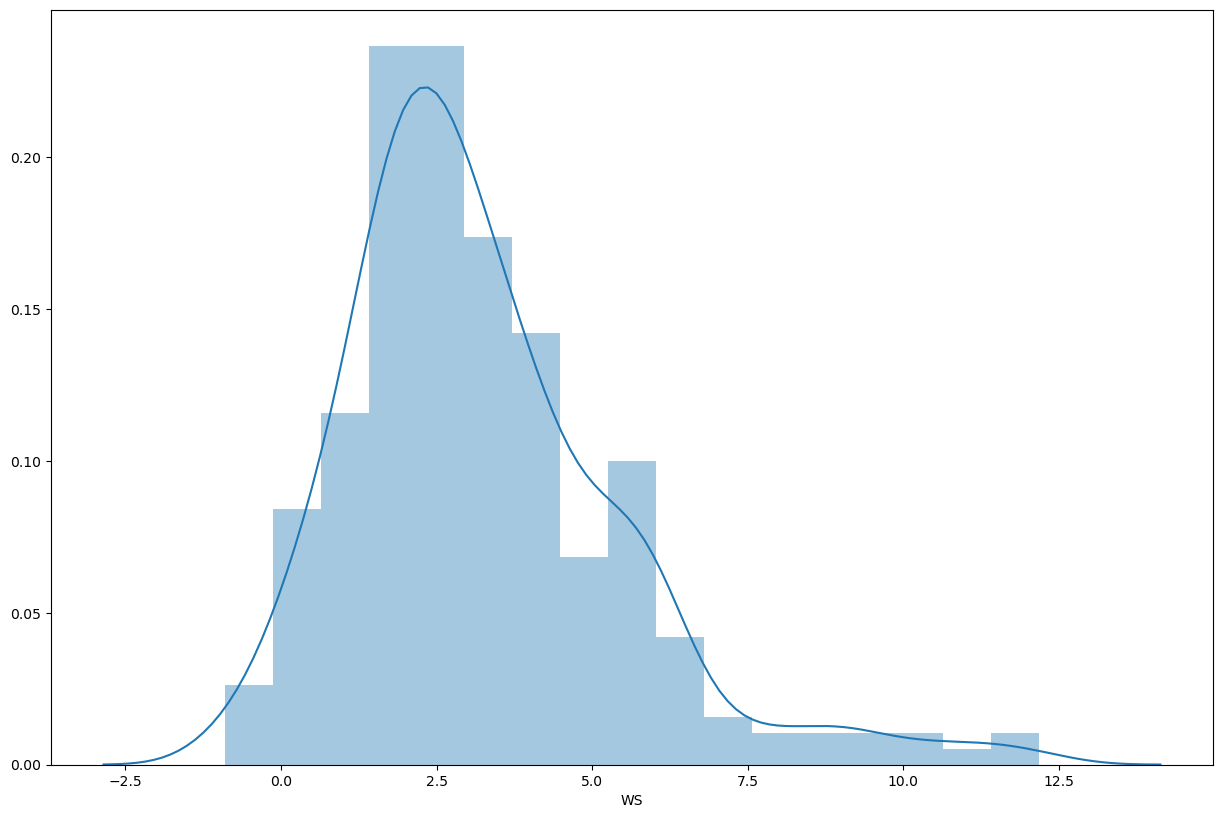

In [22]:
# let's look at the Win Share distribution for the merged data set of athletes who 
# participated in the combine, and their average win share for their 58 game seasons

plt.figure(figsize=(15,10))
plt.tight_layout()
seabornInstance.distplot(combine_subset['WS'])


Winshare for our combine data appears to be a "near normal" distribution, and we see the expected pattern of things being skewed left. 

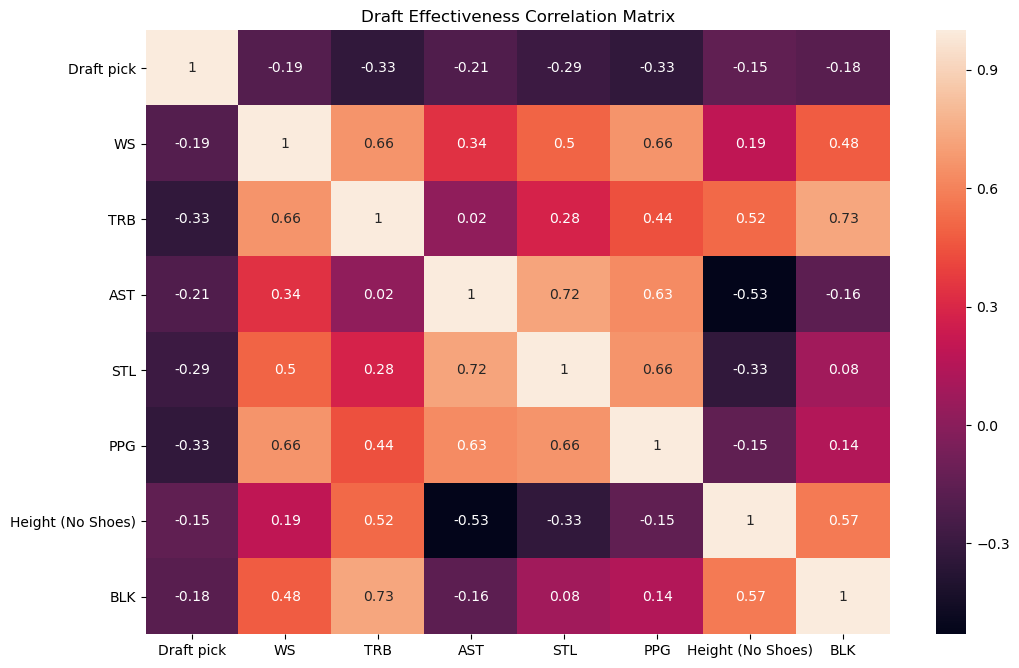

In [23]:
# plot a correlation matrix 

draft_corr = combine_subset.corr().round(2)
sns.heatmap(data=draft_corr, annot=True)
plt.title('Draft Effectiveness Correlation Matrix')
plt.savefig('visualizations/draft_correlations.png', bbox_inches='tight', 
            pad_inches=0.1)


Looking at the correlation matrix, we see that the correlation between draft position and stats like PPG, STL is weak at best, there is a relationship, but it isn't significant. Let's look at linear model plot of this data 


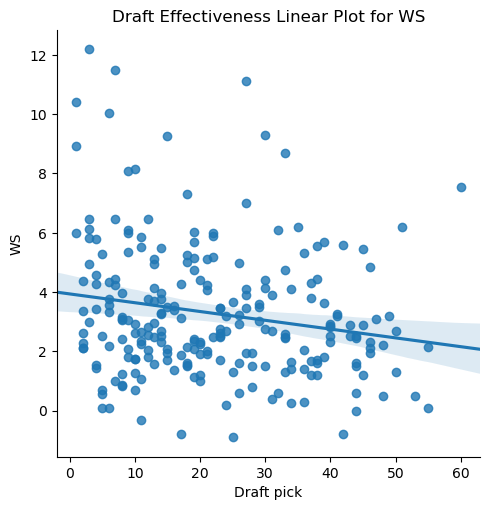

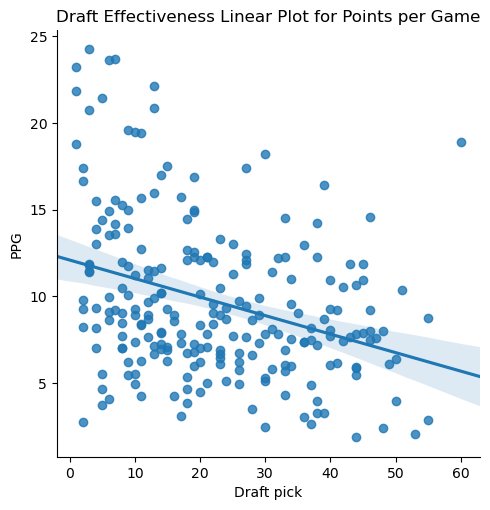

In [24]:
# linear plot to visualize the correlation between draft position and win share

sns.lmplot(x='Draft pick', y='WS', data=combine_subset)
plt.title('Draft Effectiveness Linear Plot for WS')
plt.savefig('visualizations/draft_plot.png', bbox_inches='tight', 
            pad_inches=0.1)

# linear plot to visualize the correlation between draft position and PPG
sns.lmplot(x='Draft pick', y='PPG', data=combine_subset)
plt.title('Draft Effectiveness Linear Plot for Points per Game')
plt.savefig('visualizations/draft_ppg_plot.png', bbox_inches='tight', 
            pad_inches=0.1)

The relationship we see is that while the top players in the league do tend to have been first round or low draft picks not all low draft picks turn out to be great players. Looking at the graph the trend seems to be that high performing first round draft picks are outliers, while being above average looks to be 50/50 odds. From our earlier analysis we know that average PPG is 11.2 and average win share is 4.43, so let's use that information to evaluate just how many of those players perform above average.


In [25]:
# first we isolate the athletes taken in the top 15% of the draft 

high_draft = combine_subset[(combine_subset['Draft pick'] <= 15)]
high_draft.shape

(93, 8)

We had 247 total athletes and 89 or 37.65% were taken in the top 25% (first 15 picks) of the draft, which gives us another finding: regardless of performance trends, higher draft picks do at least seem to be more likely to play a 58 game season. This isn't particularly surprising given the investment teams make into those players. 

In [27]:
# nba_subset.loc[:,'PPG'] = nba_subset['PTS'] / nba_subset['G']

# add columns for above average, below average, top 25%, not top 25% to make counting in each category
# as well as calculating sample proportions for the purposes of statistical signifigance tests easier. 

# add the above_average, below average columns 


avg_ws = nba_subset['WS'].mean()
avg_ppg = nba_subset['PPG'].mean()


high_draft.loc[:, 'ws_above_average'] = high_draft.loc[:,'WS'].apply(lambda x: 0 if x <= avg_ws else 1)
high_draft.loc[:, 'ws_below_average'] = high_draft.loc[:,'WS'].apply(lambda x: 0 if x >= avg_ws else 1)
high_draft.loc[:, 'ppg_above_average'] = high_draft.loc[:,'PPG'].apply(lambda x: 0 if x <= avg_ppg else 1)
high_draft.loc[:, 'ppg_below_average'] = high_draft.loc[:,'PPG'].apply(lambda x: 0 if x >= avg_ppg else 1)


high_draft

,Draft pick,WS,TRB,AST,STL,PPG,Height (No Shoes),BLK,ws_above_average,ws_below_average,ppg_above_average,ppg_below_average
0,3.0,12.180000,400.000000,474.300000,118.900000,24.220056,76.00,38.300000,1,0,1,0
1,7.0,11.475000,347.875000,517.500000,135.125000,23.666221,74.00,17.250000,1,0,1,0
3,1.0,10.400000,705.666667,127.333333,91.833333,23.184079,81.25,164.333333,1,0,1,0
4,6.0,10.042857,327.000000,497.000000,76.142857,23.635619,73.75,24.428571,1,0,1,0
6,15.0,9.257143,415.428571,157.428571,115.857143,17.481569,78.00,43.428571,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
225,10.0,0.700000,72.000000,100.000000,30.500000,7.366595,72.75,3.000000,0,1,0,1
229,5.0,0.550000,131.500000,154.500000,31.000000,5.517554,76.50,13.000000,0,1,0,1
239,6.0,0.100000,191.000000,356.000000,82.000000,13.506173,71.25,2.000000,0,1,1,0
240,5.0,0.100000,166.000000,188.000000,78.000000,3.756410,75.00,36.000000,0,1,0,1


In [28]:
# count how many athletes above average for WS 

ws_above_count = high_draft['ws_above_average'].sum()
ws_below_count = high_draft['ws_below_average'].sum()

ws_above_count

31

In [36]:
# count how many athletes above average for PPG and calculate N 

ppg_above_count = high_draft['ppg_above_average'].sum()
ppg_below_count = high_draft['ppg_below_average'].sum()
n = len(high_draft)
ppg_above_count


43

In [30]:
import statsmodels.api as sm

# null hypothesis: 50/50 chance of selecting an above average player or 
# an average player in the top 15 picks of the draft 
# alternate hypothesis: the % of top 15 draft picks that are high scorers will 
# be greater than those that are low scorers 


pnull = 0.50
phat = ppg_above_count/n

# ppg_null


sm.stats.proportions_ztest(phat * n, n, pnull, alternative='larger')




(-0.7279311237543241, 0.7666721251426709)

Looking the above we see that with a p-value of 0.767 we can't reject the null hypothesis, meaning: in all likelihood the NBA's evaluation procedures are a little better than a coin flip from the perspetive of a high draft pick being an above average scorer. 

In [34]:
high_draft.loc[:, 'ws_above_75th%'] = high_draft.loc[:,'WS'].apply(lambda x: 0 if x <= 5.7 else 1)
high_draft.loc[:, 'ws_below_75th%'] = high_draft.loc[:,'WS'].apply(lambda x: 0 if x >= 5.7 else 1)
high_draft.loc[:, 'ppg_above_75th%'] = high_draft.loc[:,'PPG'].apply(lambda x: 0 if x <= 14.082 else 1)
high_draft.loc[:, 'ppg_below_75th%'] = high_draft.loc[:,'PPG'].apply(lambda x: 0 if x >= 14.082 else 1)


high_draft

,Draft pick,WS,TRB,AST,STL,PPG,Height (No Shoes),BLK,ws_above_average,ws_below_average,ppg_above_average,ppg_below_average,ws_above_75th%,ws_below_75th%,ppg_above_75th%,ppg_below_75th%
0,3.0,12.180000,400.000000,474.300000,118.900000,24.220056,76.00,38.300000,1,0,1,0,1,0,1,0
1,7.0,11.475000,347.875000,517.500000,135.125000,23.666221,74.00,17.250000,1,0,1,0,1,0,1,0
3,1.0,10.400000,705.666667,127.333333,91.833333,23.184079,81.25,164.333333,1,0,1,0,1,0,1,0
4,6.0,10.042857,327.000000,497.000000,76.142857,23.635619,73.75,24.428571,1,0,1,0,1,0,1,0
6,15.0,9.257143,415.428571,157.428571,115.857143,17.481569,78.00,43.428571,1,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225,10.0,0.700000,72.000000,100.000000,30.500000,7.366595,72.75,3.000000,0,1,0,1,0,1,0,1
229,5.0,0.550000,131.500000,154.500000,31.000000,5.517554,76.50,13.000000,0,1,0,1,0,1,0,1
239,6.0,0.100000,191.000000,356.000000,82.000000,13.506173,71.25,2.000000,0,1,1,0,0,1,0,1
240,5.0,0.100000,166.000000,188.000000,78.000000,3.756410,75.00,36.000000,0,1,0,1,0,1,0,1


In [35]:
# count number of athletes taken in the top 25% of the draft that produce win shares in the 75th percentile:

ws_above_count = high_draft['ws_above_75th%'].sum()
ws_above_count_per = ws_above_count/n 

print('# of athletes who produced win shares in the 75th percentile:', ws_above_count)
print('% of athletes who produced win shares in the 75th percentile:', ws_above_count_per)


# of athletes who produced win shares in the 75th percentile: 18
% of athletes who produced win shares in the 75th percentile: 0.1935483870967742


In [33]:
ppg_above_count = high_draft['ppg_above_75th%'].sum()
ppg_above_count_per = ppg_above_count/n 

print('# of athletes who produced win shares in the 75th percentile:', ppg_above_count)
print('% of athletes who produced win shares in the 75th percentile:', ppg_above_count_per)

# of athletes who produced win shares in the 75th percentile: 26
% of athletes who produced win shares in the 75th percentile: 0.27956989247311825


Let's summarize the current findings: 

* Only 31/93 athletes taken in the top 15 picks of the draft were at or above average in terms of win share or roughly 33%
* 43/93 athletes were above average in terms of PPG, but according to our statistical significance tests, the difference between above and below average isn't statistically significant. Meaning: when it comes to PPG it's roughly 50/50 whether or not a top 15 draft pick scores more than average 
* 93/247 athletes were picked in the top 25% of the draft or 40% of our athletes, the number would've been 25% if every draft position had an equal chance of playing at least one 58 game season. This means that at the very least, higher draft picks get more playing time, probably due to some combination of the team's investment, expectations and talent. 
* 19.35% of the athletes (18 total) selected in the top 15 of the draft produced win shares in the 75th percentile 
* 27.96% of the athletes (26 total) selected in the top 15 of the draft produced PPG in the 75th percentile 

In [37]:
# analyze the data with just the data we have full combine data for 

full_combine = combine_nba_merge.dropna()
full_combine.shape


(102, 31)

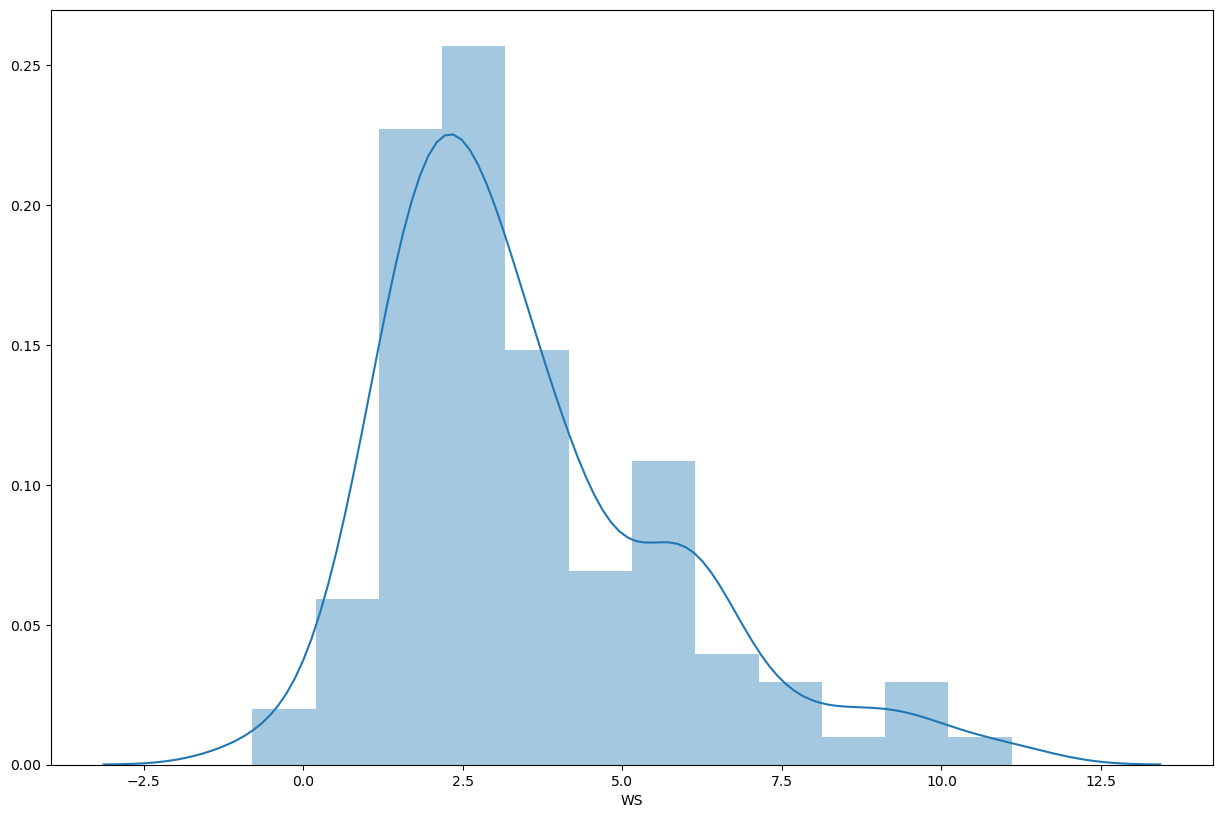

In [38]:
# let's take a look at the Win Share distribution 

plt.figure(figsize=(15,10))
plt.tight_layout()
seabornInstance.distplot(full_combine['WS'])



Text(0.5, 1.0, 'Do Combine Measurements Correlate to In Game Performance?')

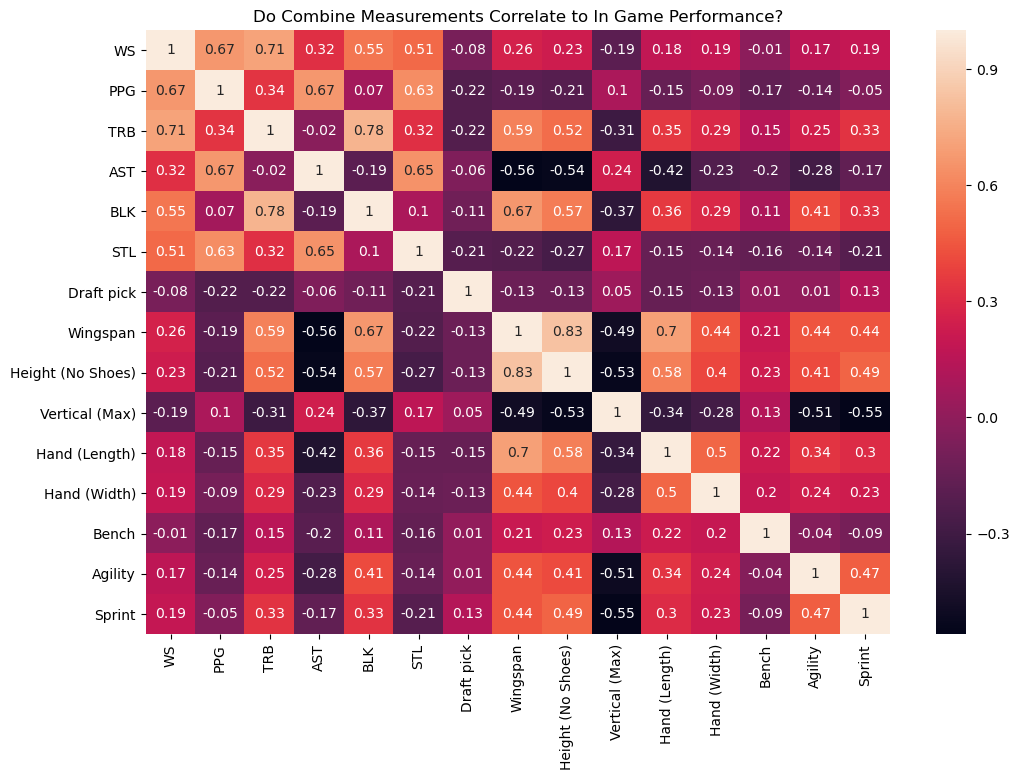

In [39]:

# compute correlation matrix

combine_correlation = full_combine[['WS', 'PPG', 'TRB', 'AST', 'BLK', 'STL', 'Draft pick', 'Wingspan', 'Height (No Shoes)', 'Vertical (Max)', 'Hand (Length)',
                                    'Hand (Width)', 'Bench', 'Agility', 'Sprint']]

combine_corr = combine_correlation.corr().round(2)
sns.heatmap(data=combine_corr, annot=True)
plt.title('Do Combine Measurements Correlate to In Game Performance?')


According to the correlation matrix there doesn't seem to be a strong correlation between any of the selected combine measurements and win share or PPG, as the "strongest" coefficients were:

* 0.26 for wingspan and winshare 
* 0.19 for sprint and winshare 
* 0.23 for height and winshare 
* -0.22 and -0.26 for PPG vs. draft pick and height respectively

We also had some near strong coefficients for in game stats outside of our primary ones: 
* 0.67 for wingspan and blocks 
* 0.59 for wingspan and total rebounds 


We also have some other relationships that are "stronger" than most, but those are probably more a factor of the bodytypes that play certain positions. 

* -0.56 and -0.55 for wingspan and height respectively vs. assists, which is probably more a reflection of the fact that players that play positions like point guard that create more assists tend to be shorter than larger athletes that play center or power forward. 

Going back to the Kevin Durant example, bench press had the weakest relationships of any combine measurement with win share and PPG (-0.01 and -0.17 respectively), supporting Kevin's claim that on court skills matter more than things like strength and speed. 

The strongest relationships were between the individual combine measurements, however, they're more a function of human anatomy, however the interesting thing is that height and hand length don't have a strong correlation. 
* Height and wingspan(0.83)
* Hand length and wingspan (0.7) 


If we were going to do a regression or similar analysis we might have to take certain correlated independent variables out to avoid collinearity, but we don't have a strong enough relationship between WS or PPG to pursue that avenue. We also don't see a strong correlation between any of the combine measurements and draft position. 



Text(0.5, 1.0, 'Height vs. WS')

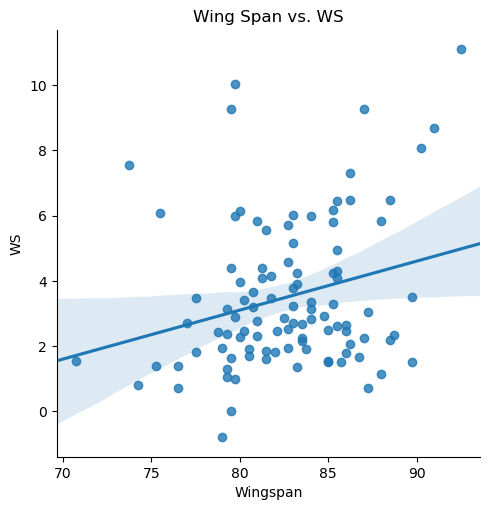

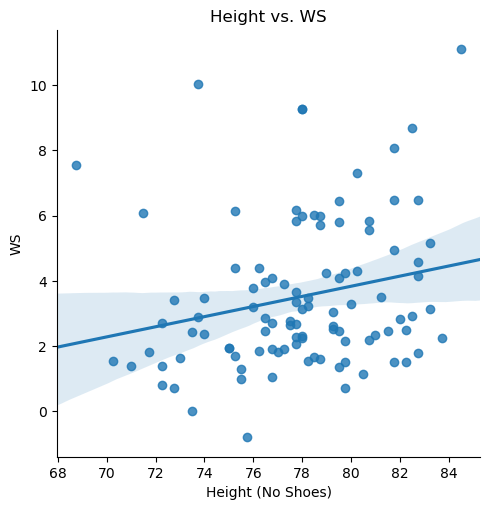

In [41]:
# what does a linear plot look like for the strongest correlators for win share? 

# linear plot to visualize the correlation between WS and Wingspan
sns.lmplot(x='Wingspan', y='WS', data=combine_correlation)
plt.title('Wing Span vs. WS')


# linear plot to visualize the correlation between WS and Agility
sns.lmplot(x='Height (No Shoes)', y='WS', data=combine_correlation)
plt.title('Height vs. WS')

Both linear plots show a fairly weak relationship between height and win shares and wingspan and win shares. Similar to the draft there is a trend where the players with the best win shares will tend to be taller or have long arms, but only a minority of all the players with those characteristics will put up above average numbers. So while all things being equal the larger athlete will perform better, the NBA doesn't appear to have found a way to get to a point where one could definitively say that "all things are equal" between two athletes. 

Summarizing all of our findings: 
 
* There doesn't seem to be any significant relationship between the combine measurements and win share or PPG, which supports the idea that the combine isn’t of much value to teams. 
* One area where the combine could show value is that if a team is trying to decide between players who appear to be of similar skill, choosing the taller player or the athlete with longer arms should result in better defensive numbers in terms of blocks and rebounds. 
* There wasn’t a significant relationship between combine performance and draft position, thus supporting the idea that the combine doesn’t help players.  
* 19.35% of the athletes (18 total) selected in the top 15 of the draft produced win shares in the 75th percentile 
* 27.96% of the athletes (26 total) selected in the top 15 of the draft produced PPG in the 75th percentile 
* The game's best players were nearly always top draft picks, but a top draft pick is not necessarily going to be a top player, in fact the odds are against a top draft pick being a top player. 
* Only 31/93 (33%) athletes taken in the top 15 picks of the draft were at or above average in terms of win share
* 43/93 athletes were above average in terms of PPG, but according to our statistical significance tests, the was no real difference between the % of players above or below the PPG average. Meaning: when it comes to PPG it's roughly 50/50 whether or not a top 15 draft pick is going to be an above average scorer.  
* 93/247 athletes were picked in the top 25% of the draft or 37.65% of the athletes in the data set a the number that would've been 25% if every draft position had an equal chance of playing at least one 58 game season, this means that at the very least, higher draft picks get more playing time, probably due to some combination of the team's investment, expectations and talent. 

Overall it doesn't appear that the NBA has the "formula" to identify above average players, because while the best players do tend to be high draft picks, the odds of a top draft being above average is 50/50 at best and barely 28% will perform in the 75th percentile for PPG and barely 20% will reach that level for win shares. It also doesn’t appear that the combine has much value in terms of giving teams additional information to evaluate players with, as the data collected doesn’t appear to be particularly relevant to in game performance outside of blocks. While our data set was small and barely spanned a decade, it does appear that on a preliminary basis <a href="https://abcnews.go.com/Sports/kevin-durant-calls-nba-combine-waste-time-top/story?id=47338234" target="new"> NBA star Kevin Durant was correct</a> when he asserted that the NBA Combine was a "waste of time" as it wasn't relevant to basketball. It's worth noting that Kevin was ranked near the bottom for combine performances as far as the athletic measurements (speed, agility, strength and jumping ability), but was selected number two overall and is already a future hall of famer with multiple years of being one of the NBA's best ahead of him. 





Future Improvements:

1. Get a broader dataset that has data spanning at least 20 seasons.
2. Use the above to re-analyze draft position vs. in game performance 
3. Acquire 20 years of combine data to see if the trends change with more data 
4. Create a visualization showing how many players from a given draft were above average, to see if the NBA's evaluation methods have improved over time
5. See if I can repeat the above for the WNBA to see if evaluating patterns are similar to the NBA

